In [1]:
import scanpy as sc
from lightning.pytorch import Trainer, seed_everything

from scprint import scPrint
from scprint.tasks import Embedder

from scdataloader import Preprocessor
from scdataloader.utils import load_genes, translate

import numpy as np
import pandas as pd

from scib_metrics.benchmark import Benchmarker

import matplotlib.pyplot as plt

from collections import Counter

%load_ext autoreload
%autoreload 2

import torch
torch.set_float32_matmul_precision('medium')


💡 loaded instance: jkobject/scprint


## preparing the model

In [4]:
#model = scPrint.load_from_checkpoint('../../data/tensorboard/scprint_test/urxxwu28/checkpoints/epoch=0-step=20000.ckpt') #chocolate-surf-8
model = scPrint.load_from_checkpoint('../../data/temp/pk2sldhk/epoch=6-step=35000.ckpt', precpt_gene_emb = '../../data/temp/embeddings.parquet')
# ../../data/temp/epoch=4-step=12500.ckpt latest model maestro (fortuitous laugther)
# ../../data/logs/scprint_test/f4vao230/checkpoints/epoch=10-step=27500.ckpt looked good as a training run (vermlillion noodle)
# d1792z9k/epoch=3-step=10000.ckpt
# '../../data/temp/d1792z9k/epoch=3-step=10000.ckpt'
# '../../data/temp/6q3dzi3x/epoch=3-step=10000.ckpt'
# '../../data/temp/grsachbg/epoch=2-step=15000.ckpt'
## post debug
# "../lightning_logs/version_14/checkpoints/epoch=1-step=5000.ckpt"

/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/lightning/pytorch/utilities/migration/utils.py:55: PossibleUserWarning: The loaded checkpoint was produced with Lightning v2.2.0.post0, which is newer than your current Lightning version: v2.0.9.post0
  rank_zero_warn(


scPrint(
  (gene_encoder): GeneEncoder(
    (embedding): Embedding(33890, 256)
    (enc_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (expr_encoder): ContinuousValueEncoder(
    (encoder): ModuleList(
      (0): Linear(in_features=1, out_features=256, bias=True)
      (1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (2): ReLU()
      (3): Dropout(p=0.1, inplace=False)
    )
  )
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (label_encoder): CategoryValueEncoder(
    (embedding): Embedding(8, 256)
    (enc_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  )
  (depth_decoder): ContinuousValueEncoder(
    (encoder): ModuleList(
      (0): Linear(in_features=1, out_features=256, bias=True)
      (1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (2): ReLU()
      (3): Dropout(p=0.1, inplace=False)
    )
  )
  (transformer): FlashTransformerEn

## Loading the data

In [ ]:
#only dataset dropped
adata = sc.read_h5ad('/home/ml4ig1/scprint/.lamindb/z7ZZxORUQFshySbuvNW7.h5ad') 

# one that it trained on: z7ZZxORUQFshySbuvNW7.
# untrained on: BljRloq1xjcxRNDpejzI

In [5]:
adata = sc.read(
    "data/pancreas_atlas.h5ad",
    backup_url="https://figshare.com/ndownloader/files/24539828",
)


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [ ]:
adata = sc.read(
    "data/lung_atlas.h5ad",
    backup_url="https://figshare.com/ndownloader/files/24539942",
)

/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [6]:
preprocessor = Preprocessor(subset_hvg=1000, use_layer='counts', is_symbol=True, force_preprocess=True, skip_validate=True, do_postp=False)

In [7]:
adata.obs['organism_ontology_term_id'] = "NCBITaxon:9606"
adata = preprocessor(adata.copy())

Data is not raw counts, please check layers, find raw data, or bypass with force_preprocess
Removed 0 genes.
Seeing 4678 outliers (28.56% of total dataset):


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:61: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


In [33]:
adata

View of AnnData object with n_obs × n_vars = 16382 × 70116
    obs: 'tech', 'celltype', 'size_factors', 'organism_ontology_term_id', 'nnz', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier'
    var: 'uid', 'symbol', 'stable_id', 'ncbi_gene_ids', 'biotype', 'description', 'synonyms', 'organism_id', 'public_source_id', 'created_at', 'updated_at', 'created_by_id', 'mt', 'ribo', 'hb', 'organism', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'unseen_genes', 'hvg'
    layers: 'clean'

In [ ]:
sc.pl.umap(adata, color=["cell_type", "development_stage", "assay", "disease", "sex", "self_reported_ethnicity"])

In [8]:
Counter(adata.obs.celltype)

Counter({'alpha': 5493,
         'beta': 4169,
         'ductal': 2142,
         'acinar': 1669,
         'delta': 1055,
         'gamma': 699,
         'activated_stellate': 464,
         'endothelial': 313,
         'quiescent_stellate': 193,
         'macrophage': 79,
         'mast': 42,
         'epsilon': 32,
         'schwann': 25,
         't_cell': 7})

# good dataset

In [24]:
trainer = Trainer(precision="16-mixed")

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [27]:
from scdataloader.data import SimpleAnnDataset
from scdataloader import Collator
from torch.utils.data import DataLoader

In [29]:
organisms=[
    "NCBITaxon:9606",
]
subadata = adata[adata.obs.celltype=="gamma"]
subadata.obs['organism_ontology_term_id'] = organisms[0]
print(subadata)

sc.pp.highly_variable_genes(subadata, n_top_genes=3000, flavor='seurat_v3')
highly_variable = subadata.var.index[subadata.var.highly_variable].tolist()
print((subadata.X.sum(0)>1).sum())

adataset = SimpleAnnDataset(
    subadata, obs_to_output=["organism_ontology_term_id"]
)
col = Collator(
    organisms=organisms,
    valid_genes=model.genes,
    how="some",
    genelist=highly_variable,
)
dataloader = DataLoader(
    adataset,
    collate_fn=col,
    batch_size=64,
    num_workers=1,
    shuffle=False,
)
model.get_attention_layer=[3]
# self.trainer.num_predict_batches = 1

/tmp/ipykernel_350737/63406948.py:5: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  subadata.obs['organism_ontology_term_id'] = organisms[0]


AnnData object with n_obs × n_vars = 699 × 70116
    obs: 'tech', 'celltype', 'size_factors', 'organism_ontology_term_id', 'nnz', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier'
    var: 'uid', 'symbol', 'stable_id', 'ncbi_gene_ids', 'biotype', 'description', 'synonyms', 'organism_id', 'public_source_id', 'created_at', 'updated_at', 'created_by_id', 'mt', 'ribo', 'hb', 'organism', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'unseen_genes', 'hvg'
    layers: 'clean'


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:61: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


15268



LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

         Falling back to preprocessing with `sc.pp.pca` and default params.


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 699 × 256
    obs: 'pred_cell_type_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'conv_pred_cell_type_ontology_term_id', 'conv_pred_disease_ontology_term_id', 'conv_pred_assay_ontology_term_id', 'conv_pred_self_reported_ethnicity_ontology_term_id', 'leiden'
    uns: 'neighbors', 'umap', 'leiden'
    obsm: 'X_pca', 'X_umap'
    obsp: 'distances', 'connectivities'


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in panda

couldn't log to tensorboard
couldn't log to wandb


[None, None, None, None, None, None, None, None, None, None, None]

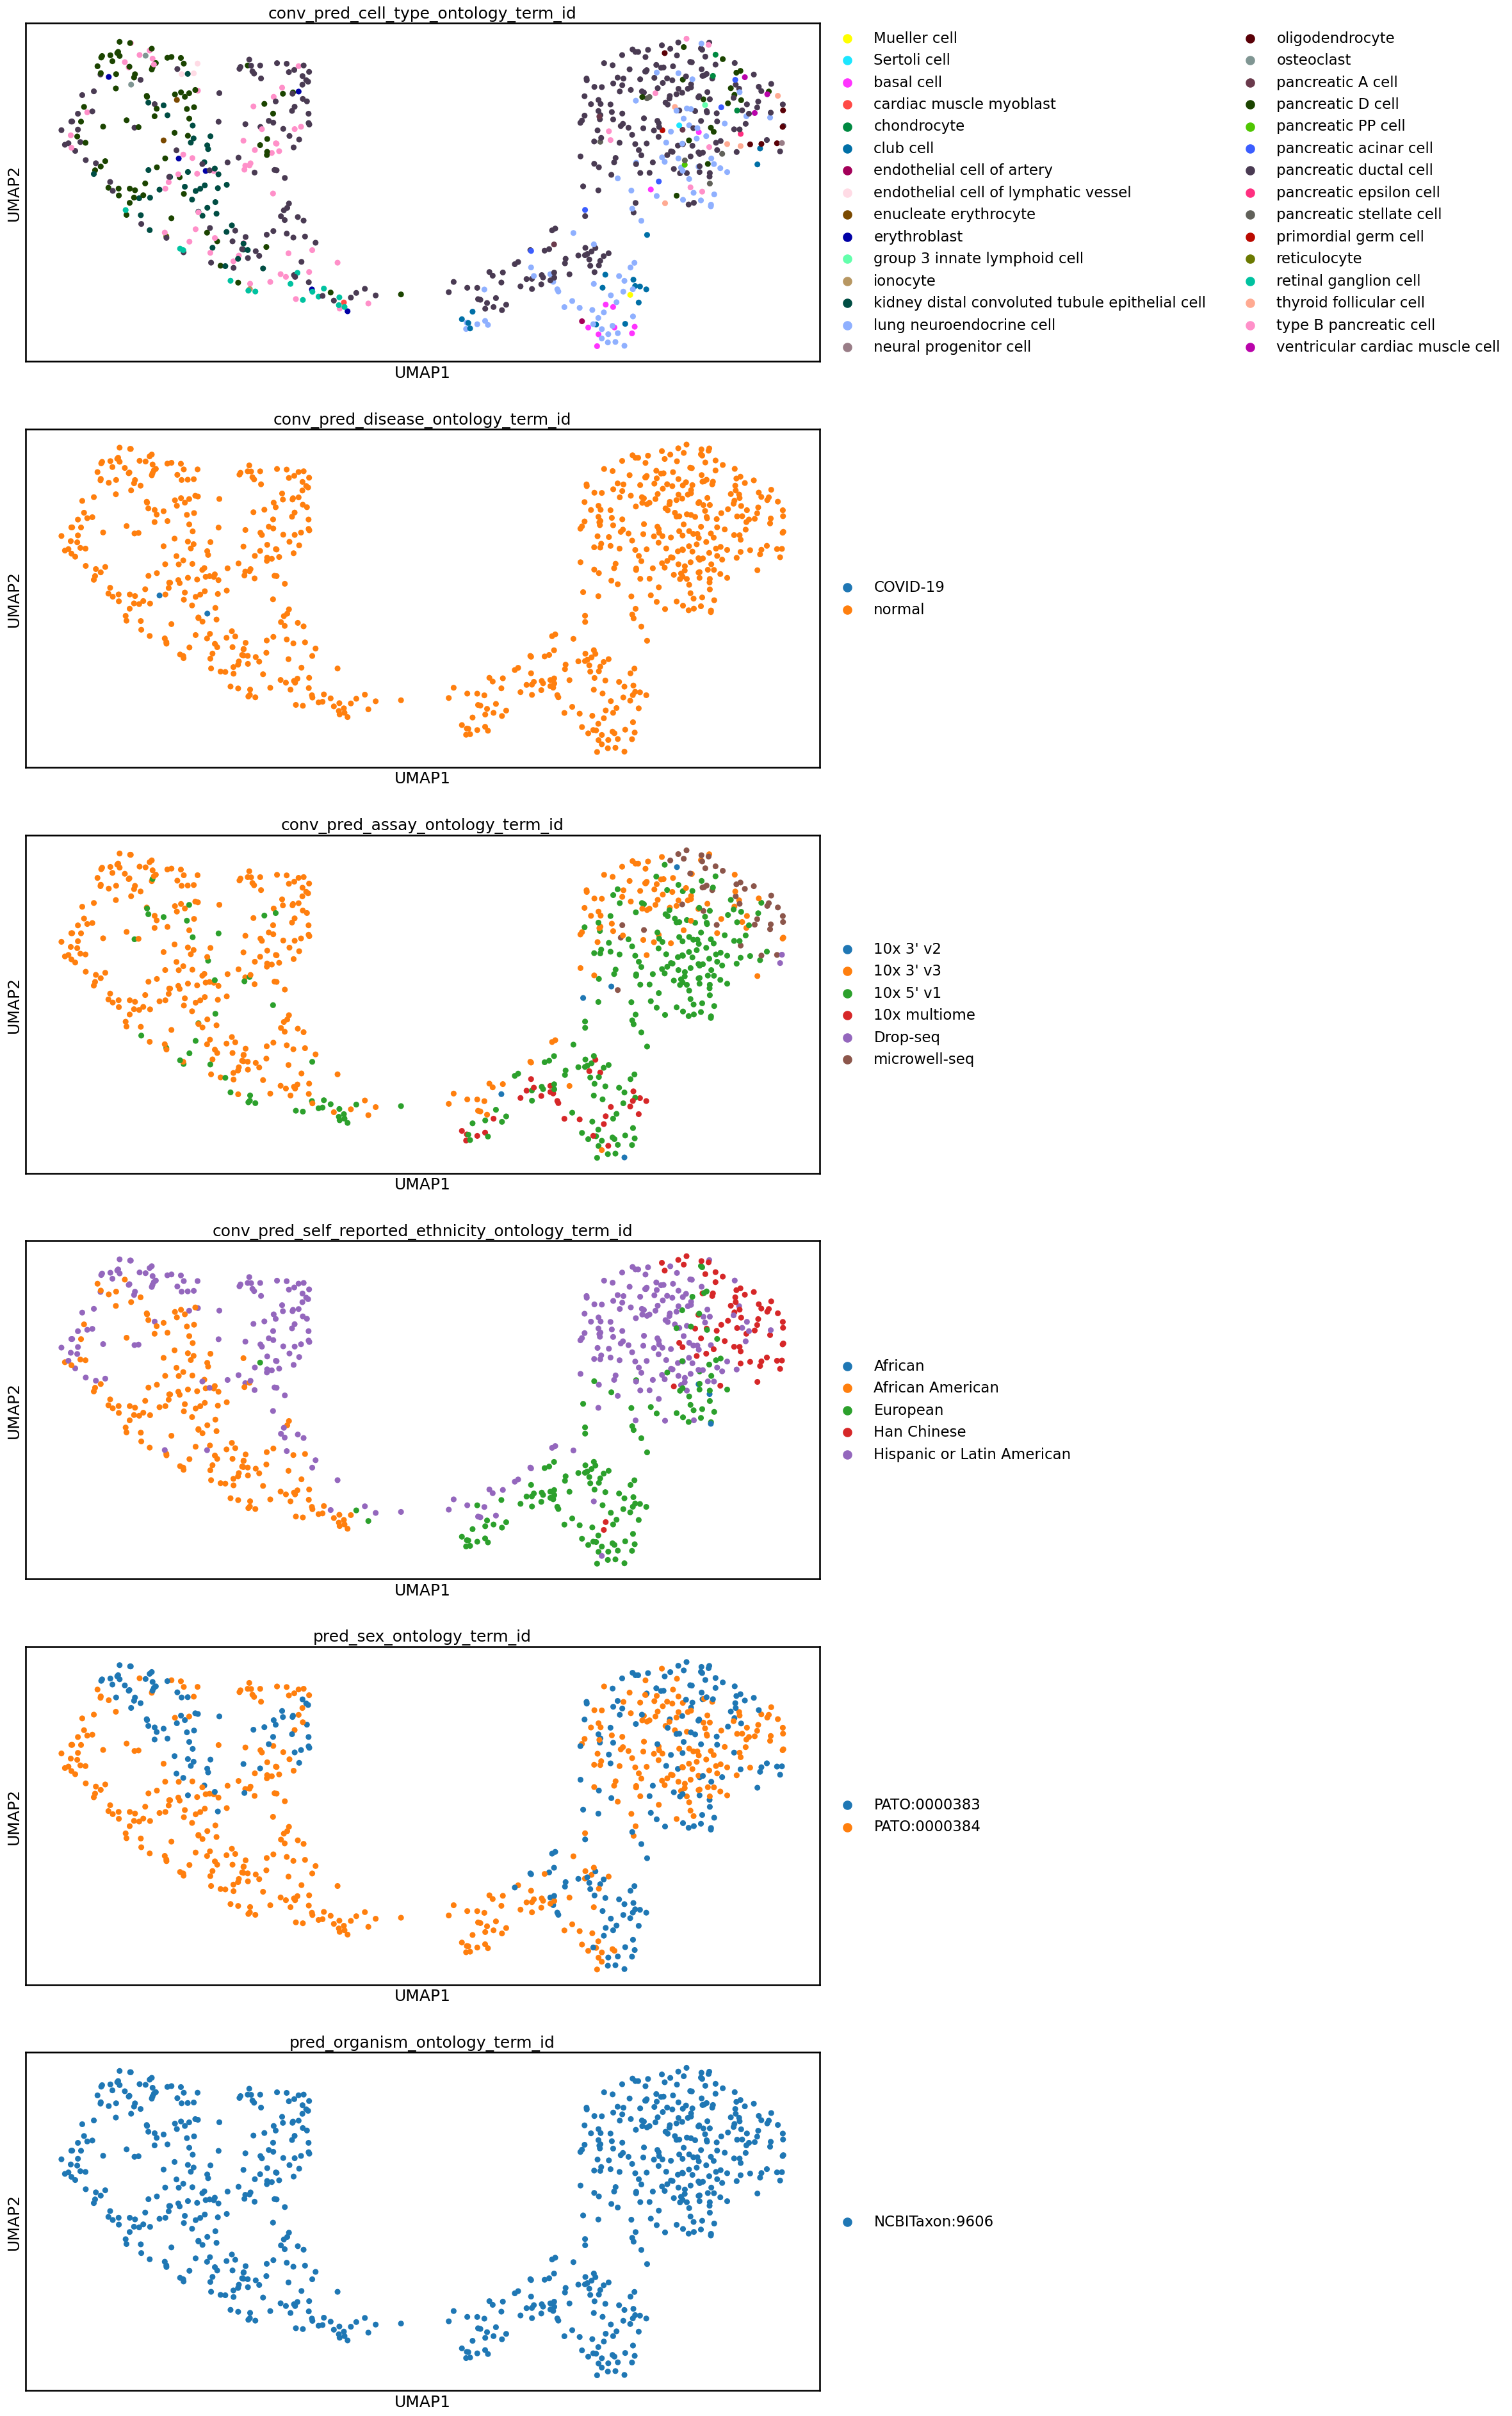

In [35]:
trainer.predict(model, dataloader)

In [31]:
from scprint.utils.sinkhorn import SinkhornDistance

In [40]:
model.mean_attn[0][:,0,:,:].permute(1,0,2).shape

torch.Size([4, 2984, 64])

In [41]:
attn = model.mean_attn[0][:,0,:,:].permute(1,0,2) @ model.mean_attn[0][:,1,:,:].permute(1,2,0)
scale = model.mean_attn[0].shape[-1] ** -0.5
attn = attn * scale

sink = SinkhornDistance(0.1, max_iter=200)
a = sink(attn)[0]
a = a * a.shape[-1]

a = a.mean(0).detach().cpu().numpy()
print("avg link count: "+str((a>(3/attn.shape[-1])).sum() / attn.shape[-1]))
a[a.mean(0)<(3/a.shape[-1])] = 0

avg link count: 55.92225201072386



In [42]:
a.shape

(2984, 2984)

In [43]:
from grnndata import GRNAnnData
from grnndata import utils 

View of AnnData object with n_obs × n_vars = 699 × 2976
    obs: 'tech', 'celltype', 'size_factors', 'organism_ontology_term_id', 'nnz', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier'
    var: 'uid', 'symbol', 'stable_id', 'ncbi_gene_ids', 'biotype', 'description', 'synonyms', 'organism_id', 'public_source_id', 'created_at', 'updated_at', 'created_by_id', 'mt', 'ribo', 'hb', 'organism', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'unseen_genes', 'hvg'
    layers: 'clean'

In [45]:
grn = GRNAnnData(subadata[:,col.accepted_genes[organisms[0]]][:,col.to_subset[organisms[0]]].copy(), grn=a)

ValueError: Value passed for key 'GRN' is of incorrect shape. Values of varp must match dimensions (1, 1) of parent. Value had shape (2984, 2984) while it should have had (70116, 70116).

In [67]:
top_central_genes = utils.get_centrality(grn)
grn.var.loc[[i[0] for i in top_central_genes],'feature_name']

grn.var_names = grn.var['feature_name']
grn.var['TFs'] = [True if i in utils.TF else False for i in grn.var_names]

grn.write('grn.h5ad')

torch.Size([4, 1497, 1497])

In [ ]:
res = utils.enrichment(grn, of='Central')

In [ ]:
utils.enrichment(grn, of='Regulators')

In [ ]:
utils.enrichment(grn, of='Targets')

In [119]:
torch.cuda.empty_cache()